Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [1]:
import json
import pandas as pd
import requests
import geopy
from geopy import distance
from geopy.distance import geodesic
import scipy.stats as stats
from scipy import stats
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
import seaborn as sns
import matplotlib.pyplot as plt

# Join Yelp to City Bike data

Now we want to take our 1,000 restaurants from Yelp and join them to our stations in a full outer join.
This should result in a dataframe with 123,000 rows. Don't worry, there's a good reason! 

In [3]:
test = pd.DataFrame(bikes_center.merge(yelp_restaurants, how='outer', on='mergevar'))
test.to_csv(r'C:\Users\ca0pa\Desktop\LHL\Python\test.csv', index=False)
test

This seems to have done what I wanted, by visual inspection. Let's make it official!

In [ ]:
bikestation = pd.DataFrame(test)

Let's clean up and rename some columns to make it easier to work with.

In [ ]:
bikestation = pd.DataFrame(bikestation.rename(columns={"name": "station", "id": "stn_id", "distance_from_center":"stn_dist_to_center"}))
bikestation = pd.DataFrame(bikestation.rename(columns={"distance": "rst_dist_to_center_m", "review_count": "rest_review_count", 
                                                       "stn_dist_to_center":"stn_dist_to_center_km"}))
bikestation = pd.DataFrame(bikestation.rename(columns={"rating": "rest_rating", "lat": "rest_lat", "lon":"rest_lon"}))

In [5]:
bikestation.to_csv(r'C:\Users\ca0pa\Desktop\LHL\Python\bikestation_all_yelp.csv', index=False)
bikestation = pd.read_csv('bikestation_all_yelp.csv')
bikestation

,empty_slots,free_bikes,stn_id,latitude,longitude,station,timestamp,stn_dist_to_center_km,mergevar,rest_name,rest_review_count,rest_rating,rst_dist_to_center_m,rest_lat,rest_lon,rest_dist_to_stn_km
0,15,23,7f0baf8054547e62f029e717f4f1ea31,60.155445,24.950293,Kaivopuisto,2023-10-18T20:35:03.826000Z,2.001855,1,Kahvihuone,2,4.5,176.150839,60.190808,24.948515,3.941233
1,15,23,7f0baf8054547e62f029e717f4f1ea31,60.155445,24.950293,Kaivopuisto,2023-10-18T20:35:03.826000Z,2.001855,1,Mikura Sushi,4,4.5,181.205186,60.190763,24.947253,3.938614
2,15,23,7f0baf8054547e62f029e717f4f1ea31,60.155445,24.950293,Kaivopuisto,2023-10-18T20:35:03.826000Z,2.001855,1,MusKan,2,4.0,185.559703,60.191341,24.945235,4.009251
3,15,23,7f0baf8054547e62f029e717f4f1ea31,60.155445,24.950293,Kaivopuisto,2023-10-18T20:35:03.826000Z,2.001855,1,Alppilan Huone,3,3.0,187.792525,60.191130,24.946910,3.980307
4,15,23,7f0baf8054547e62f029e717f4f1ea31,60.155445,24.950293,Kaivopuisto,2023-10-18T20:35:03.826000Z,2.001855,1,Weeruska,22,3.5,192.060675,60.190801,24.946400,3.945189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116845,22,0,1e9ee9fdafb05635eb445e3fa8c7b505,60.188399,24.884736,Seurasaari,2023-10-18T20:35:04.186000Z,3.281873,1,Levain,2,4.0,3729.127324,60.159250,24.936410,4.332908
116846,22,0,1e9ee9fdafb05635eb445e3fa8c7b505,60.188399,24.884736,Seurasaari,2023-10-18T20:35:04.186000Z,3.281873,1,Kom-ravintola,8,4.0,3732.654620,60.158805,24.946052,4.738661
116847,22,0,1e9ee9fdafb05635eb445e3fa8c7b505,60.188399,24.884736,Seurasaari,2023-10-18T20:35:04.186000Z,3.281873,1,Sea Horse,54,4.0,3736.386785,60.158766,24.946545,4.761401
116848,22,0,1e9ee9fdafb05635eb445e3fa8c7b505,60.188399,24.884736,Seurasaari,2023-10-18T20:35:04.186000Z,3.281873,1,Saslik,22,4.5,3745.275064,60.158680,24.948509,4.847108


## Create new variable of interest by using a count of the number of restaurants Yelp returned within each of 4 distances.

Okay, now I'm going to have to calculate some new variables in order to compare the data collected from Yelp and FourSquare among 
different radiuses around our point of interest.

In [6]:
# I couldn't get this to work: I used other methods.
# bikestation['yelp_rest_250'] = bikestation.groupby('station', as_index=True).sum(bikestation['rest_dist_to_stn_km'] <= 250)
# bikestation["yelp_ct_100m"] = bikestation.groupby('station').apply(sum('within_100_m'), axis = 1)

In [7]:
def calc_dist_station(row):
    coordinate_1 = (row['latitude'], row['longitude'])
    coordinate_2 = (row['rest_lat'], row['rest_lon'])
    return geodesic(coordinate_1, coordinate_2).km

#and let's now create that new variable
bikestation["rest_dist_to_stn_km"] = bikestation.apply(calc_dist_station, axis = 1)

In [8]:
bikestation['within_100_m'] = bikestation['rest_dist_to_stn_km'] <= 0.1
bikestation['within_250_m'] = bikestation['rest_dist_to_stn_km'] <= 0.25
bikestation['within_350_m'] = bikestation['rest_dist_to_stn_km'] <= 0.35
bikestation['within_500_m'] = bikestation['rest_dist_to_stn_km'] <= 0.5

In [9]:
yelp_rest_station = pd.DataFrame(bikestation.groupby('station', as_index=False).sum('within_250_m'))
yelp_rest_station.head()

,station,empty_slots,free_bikes,latitude,longitude,stn_dist_to_center_km,mergevar,rest_review_count,rest_rating,rst_dist_to_center_m,rest_lat,rest_lon,rest_dist_to_stn_km,within_100_m,within_250_m,within_350_m,within_500_m
0,Albertinkatu,17100,2850,57153.764596,23689.964798,1003.096090,950,7248,3481.0,2.242625e+06,57166.28449,23694.789886,1606.202469,2,23,56,109
1,Annankatu,5700,10450,57155.285996,23694.682300,942.365857,950,7248,3481.0,2.242625e+06,57166.28449,23694.789886,1459.839123,15,50,79,133
2,Apollonkatu,11400,15200,57167.275810,23676.274490,753.291268,950,7248,3481.0,2.242625e+06,57166.28449,23694.789886,1622.868250,2,14,23,38
3,Arielinkatu,9500,11400,57176.625643,23730.751632,2939.056073,950,7248,3481.0,2.242625e+06,57166.28449,23694.789886,2631.986859,0,0,2,2
4,Baana,10450,4750,57155.883600,23676.437510,911.540683,950,7248,3481.0,2.242625e+06,57166.28449,23694.789886,1785.140071,0,9,19,39


In [10]:
yelp_stationrestaurants = yelp_rest_station[['station','within_250_m','within_350_m','within_500_m','within_100_m']]
yelp_stationrestaurants.describe()

,within_250_m,within_350_m,within_500_m,within_100_m
count,123.000000,123.000000,123.000000,123.000000
mean,15.471545,28.682927,55.121951,2.715447
std,23.142936,40.399707,72.121321,4.531349
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,6.000000,0.000000
50%,6.000000,13.000000,27.000000,1.000000
75%,19.500000,34.500000,62.500000,3.500000
max,114.000000,178.000000,298.000000,30.000000


In [11]:
bike_yelp = pd.DataFrame(bikestation.merge(yelp_stationrestaurants, on='station'))
bike_yelp.describe()

,empty_slots,free_bikes,latitude,longitude,stn_dist_to_center_km,mergevar,rest_review_count,rest_rating,rst_dist_to_center_m,rest_lat,rest_lon,rest_dist_to_stn_km,within_250_m_y,within_350_m_y,within_500_m_y,within_100_m_y
count,116850.000000,116850.000000,116850.000000,116850.000000,116850.000000,116850.0,116850.000000,116850.000000,116850.000000,116850.000000,116850.000000,116850.000000,116850.000000,116850.000000,116850.000000,116850.000000
mean,14.528455,10.203252,60.177015,24.936237,1.834190,1.0,7.629474,3.664211,2360.658298,60.175036,24.941884,2.214053,15.471545,28.682927,55.121951,2.715447
std,8.347495,12.730505,0.013363,0.022600,0.949181,0.0,10.025882,0.817820,834.533607,0.012084,0.014650,1.228260,23.048766,40.235318,71.827854,4.512910
min,1.000000,0.000000,60.150396,24.877286,0.048506,1.0,1.000000,1.000000,176.150839,60.153950,24.883890,0.006836,0.000000,0.000000,0.000000,0.000000
25%,9.000000,2.000000,60.165343,24.921552,1.055891,1.0,2.000000,3.000000,1839.521035,60.167000,24.933500,1.247793,1.000000,3.000000,6.000000,0.000000
50%,14.000000,6.000000,60.175592,24.937106,1.845440,1.0,4.000000,4.000000,2600.045645,60.169883,24.941815,2.118489,6.000000,13.000000,27.000000,1.000000
75%,19.000000,13.000000,60.189217,24.952160,2.666751,1.0,10.000000,4.000000,2930.040597,60.182541,24.950705,3.039192,20.000000,35.000000,63.000000,4.000000
max,40.000000,76.000000,60.201438,24.982527,3.477867,1.0,115.000000,5.000000,3756.167173,60.223166,25.007620,8.711979,114.000000,178.000000,298.000000,30.000000


## Clean up this merge - drop columns, rename columns. Get rid of all those extra rows.

In [12]:
bike_yelp.drop(columns='rest_name',inplace=True)
bike_yelp.drop(columns='rest_lon',inplace=True)
bike_yelp.drop(columns='rest_dist_to_stn_km',inplace=True)
bike_yelp.drop(columns='within_250_m_x',inplace=True)
bike_yelp.drop(columns='within_350_m_x',inplace=True)
bike_yelp.drop(columns='within_500_m_x',inplace=True)
bike_yelp.drop(columns='within_100_m_x',inplace=True)
bike_yelp.drop(columns='rest_review_count',inplace=True)
bike_yelp.drop(columns='rest_rating',inplace=True)
bike_yelp.drop(columns='rst_dist_to_center_m',inplace=True)
bike_yelp.drop(columns='rest_lat',inplace=True)

In [13]:
bike_yelp_small = pd.DataFrame(bike_yelp.drop_duplicates(subset='station'))
bike_yelp_small.to_csv(r'C:\Users\ca0pa\Desktop\LHL\Python\bike_yelp_small.csv', index=False)

In [15]:
bike_yelp_small = pd.DataFrame(bike_yelp_small.rename(columns={"within_250_m_y": "yelp_250", "within_350_m_y": "yelp_350", 
                                                               "within_500_m_y":"yelp_500","within_100_m_y":"yelp_100"}))
bike_yelp_small.drop(columns='index',inplace=True)

# Join merged City Bike and Yelp data with the FourSquare data.

In [17]:
bike_yelp_four_full = pd.DataFrame(bike_yelp_small.merge(four_wlatlong, how='outer', on='mergevar'))
bike_yelp_four_full

## Now, we'll repeat the same procedure that we did with the Yelp data to create the variables.

In [ ]:
def calc_dist_four(row):
    coordinate_1 = (row['latitude'], row['longitude'])
    coordinate_2 = (row['main.latitude'], row['main.longitude'])
    return geodesic(coordinate_1, coordinate_2).km

#and let's now create that new variable
bike_yelp_four_full["four_dist_to_stn_km"] = bike_yelp_four_full.apply(calc_dist_four, axis = 1)

In [ ]:
bike_yelp_four_full['four_100'] = bike_yelp_four_full['four_dist_to_stn_km'] <= 0.1
bike_yelp_four_full['four_250'] = bike_yelp_four_full['four_dist_to_stn_km'] <= 0.25
bike_yelp_four_full['four_350'] = bike_yelp_four_full['four_dist_to_stn_km'] <= 0.35
bike_yelp_four_full['four_500'] = bike_yelp_four_full['four_dist_to_stn_km'] <= 0.5

In [ ]:
four_boolean = pd.DataFrame(bike_yelp_four_full.groupby('station', as_index=False).sum('four_100'))
four_boolean

In [ ]:
four_countby_dist = four_boolean[['station','four_100','four_250','four_350','four_500']]
four_countby_dist

### Merge the new variables back into the dataset

In [ ]:
bike_four_wcounts = pd.DataFrame(bike_yelp_four_full.merge(four_countby_dist, on='station'))
bike_four_wcounts

Now we can clean it all up again. Get rid of all the extra rows, etc.

In [ ]:
bike_four_wcounts.drop(columns='mergevar',inplace=True)
bike_four_wcounts.drop(columns='main.longitude',inplace=True)
bike_four_wcounts.drop(columns='main.latitude',inplace=True)
bike_four_wcounts.drop(columns='four_dist_to_stn_km',inplace=True)
bike_four_wcounts.drop(columns='four_100_x',inplace=True)
bike_four_wcounts.drop(columns='four_250_x',inplace=True)
bike_four_wcounts.drop(columns='four_350_x',inplace=True)
bike_four_wcounts.drop(columns='four_500_x',inplace=True)
bike_four_wcounts.drop(columns='name',inplace=True)

In [ ]:
Helsinki_bikestation = pd.DataFrame(bike_four_wcounts.drop_duplicates(subset='station'))
Helsinki_bikestation

In [ ]:
Helsinki_bikestation.drop(columns='distance',inplace=True)

In [ ]:
Helsinki_bikestation['total_bikes'] = Helsinki_bikestation['empty_slots'] + Helsinki_bikestation['free_bikes']

In [18]:
Helsinki_bikestation.to_csv(r'C:\Users\ca0pa\Desktop\LHL\Python\Helsinki_bikestation.csv', index=False)
Helsinki_bikestation = pd.read_csv('Helsinki_bikestation.csv')
Helsinki_bikestation

,empty_slots,free_bikes,stn_id,latitude,longitude,station,timestamp,stn_dist_to_center_km,yelp_250,yelp_350,yelp_500,yelp_100,four_100_y,four_250_y,four_350_y,four_500_y,total_bikes
0,15,23,7f0baf8054547e62f029e717f4f1ea31,60.155445,24.950293,Kaivopuisto,2023-10-18T20:35:03.826000Z,2.001855,0,0,4,0,3,30,67,129,38
1,10,4,9260e3f88cfd9ede2dacf66685cc9595,60.160959,24.956347,Laivasillankatu,2023-10-18T20:35:03.845000Z,1.736349,0,0,3,0,2,22,44,97,14
2,4,14,d6df69b46a8a140b89af51eb17c69309,60.158189,24.944927,Kapteeninpuistikko,2023-10-18T20:35:03.861000Z,1.592994,8,13,25,2,6,44,85,184,18
3,10,6,fc993e236043e904c4d229a3806cb458,60.160986,24.941776,Viiskulma,2023-10-18T20:35:03.867000Z,1.236670,26,43,85,6,22,84,141,310,16
4,4,35,f21eedaefb3ce200e00b2f5ef79a86ed,60.162225,24.929710,Hietalahdentori,2023-10-18T20:35:03.875000Z,1.001732,23,43,72,8,26,81,153,270,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,15,1,bab45e7a1ef6f2643a32891f61000063,60.195260,24.900731,Kuusitie,2023-10-18T20:35:04.177000Z,3.220742,2,3,5,1,42,109,151,229,16
119,19,1,d62d22d4d4915a30713cd15020b182d9,60.188275,24.955976,Kustaankatu,2023-10-18T20:35:04.179000Z,2.311878,27,34,62,9,63,161,212,395,20
120,10,6,03cd48db7343b62ceeb8c62cefd71334,60.197533,24.899261,Tilkanvierto,2023-10-18T20:35:04.181000Z,3.477867,0,2,3,0,6,55,121,160,16
121,18,3,f22262af20d637ff4aa72678fb8f7663,60.194448,24.891118,Paciuksenkaari,2023-10-18T20:35:04.186000Z,3.473536,2,2,3,1,1,22,28,103,21


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [19]:
# EDA of final working dataset

In [20]:
Helsinki_bikestation = pd.read_csv('Helsinki_bikestation.csv')
Helsinki_bikestation

,empty_slots,free_bikes,stn_id,latitude,longitude,station,timestamp,stn_dist_to_center_km,yelp_250,yelp_350,yelp_500,yelp_100,four_100_y,four_250_y,four_350_y,four_500_y,total_bikes
0,15,23,7f0baf8054547e62f029e717f4f1ea31,60.155445,24.950293,Kaivopuisto,2023-10-18T20:35:03.826000Z,2.001855,0,0,4,0,3,30,67,129,38
1,10,4,9260e3f88cfd9ede2dacf66685cc9595,60.160959,24.956347,Laivasillankatu,2023-10-18T20:35:03.845000Z,1.736349,0,0,3,0,2,22,44,97,14
2,4,14,d6df69b46a8a140b89af51eb17c69309,60.158189,24.944927,Kapteeninpuistikko,2023-10-18T20:35:03.861000Z,1.592994,8,13,25,2,6,44,85,184,18
3,10,6,fc993e236043e904c4d229a3806cb458,60.160986,24.941776,Viiskulma,2023-10-18T20:35:03.867000Z,1.236670,26,43,85,6,22,84,141,310,16
4,4,35,f21eedaefb3ce200e00b2f5ef79a86ed,60.162225,24.929710,Hietalahdentori,2023-10-18T20:35:03.875000Z,1.001732,23,43,72,8,26,81,153,270,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,15,1,bab45e7a1ef6f2643a32891f61000063,60.195260,24.900731,Kuusitie,2023-10-18T20:35:04.177000Z,3.220742,2,3,5,1,42,109,151,229,16
119,19,1,d62d22d4d4915a30713cd15020b182d9,60.188275,24.955976,Kustaankatu,2023-10-18T20:35:04.179000Z,2.311878,27,34,62,9,63,161,212,395,20
120,10,6,03cd48db7343b62ceeb8c62cefd71334,60.197533,24.899261,Tilkanvierto,2023-10-18T20:35:04.181000Z,3.477867,0,2,3,0,6,55,121,160,16
121,18,3,f22262af20d637ff4aa72678fb8f7663,60.194448,24.891118,Paciuksenkaari,2023-10-18T20:35:04.186000Z,3.473536,2,2,3,1,1,22,28,103,21


In [21]:
type(Helsinki_bikestation)

pandas.core.frame.DataFrame

In [22]:
Helsinki_bikestation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   empty_slots            123 non-null    int64  
 1   free_bikes             123 non-null    int64  
 2   stn_id                 123 non-null    object 
 3   latitude               123 non-null    float64
 4   longitude              123 non-null    float64
 5   station                123 non-null    object 
 6   timestamp              123 non-null    object 
 7   stn_dist_to_center_km  123 non-null    float64
 8   yelp_250               123 non-null    int64  
 9   yelp_350               123 non-null    int64  
 10  yelp_500               123 non-null    int64  
 11  yelp_100               123 non-null    int64  
 12  four_100_y             123 non-null    int64  
 13  four_250_y             123 non-null    int64  
 14  four_350_y             123 non-null    int64  
 15  four_5

In [23]:
Helsinki_bikestation.describe()

,empty_slots,free_bikes,latitude,longitude,stn_dist_to_center_km,yelp_250,yelp_350,yelp_500,yelp_100,four_100_y,four_250_y,four_350_y,four_500_y,total_bikes
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,14.528455,10.203252,60.177015,24.936237,1.834190,15.471545,28.682927,55.121951,2.715447,15.902439,78.479675,149.479675,280.000000,24.731707
std,8.381601,12.782518,0.013418,0.022692,0.953059,23.142936,40.399707,72.121321,4.531349,15.777352,52.865023,89.349319,155.182917,11.185524
min,1.000000,0.000000,60.150396,24.877286,0.048506,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,12.000000
25%,9.000000,2.500000,60.165512,24.921973,1.078103,1.000000,3.000000,6.000000,0.000000,4.000000,36.000000,81.500000,179.500000,18.000000
50%,14.000000,6.000000,60.175592,24.937106,1.845440,6.000000,13.000000,27.000000,1.000000,10.000000,67.000000,135.000000,255.000000,22.000000
75%,19.000000,12.500000,60.188808,24.951591,2.644632,19.500000,34.500000,62.500000,3.500000,22.500000,105.000000,186.000000,349.000000,28.000000
max,40.000000,76.000000,60.201438,24.982527,3.477867,114.000000,178.000000,298.000000,30.000000,79.000000,232.000000,395.000000,755.000000,83.000000


In [24]:
Helsinki_bikestation.isnull().sum()

empty_slots              0
free_bikes               0
stn_id                   0
latitude                 0
longitude                0
station                  0
timestamp                0
stn_dist_to_center_km    0
yelp_250                 0
yelp_350                 0
yelp_500                 0
yelp_100                 0
four_100_y               0
four_250_y               0
four_350_y               0
four_500_y               0
total_bikes              0
dtype: int64

In [25]:
Helsinki_bikestation.sort_values(by="total_bikes", ascending=False).head(5)

,empty_slots,free_bikes,stn_id,latitude,longitude,station,timestamp,stn_dist_to_center_km,yelp_250,yelp_350,yelp_500,yelp_100,four_100_y,four_250_y,four_350_y,four_500_y,total_bikes
49,7,76,3cd8b1428d90c1cf1f3ddaac501e697f,60.153530,24.931254,Hernesaarenranta,2023-10-18T20:35:04.092000Z,1.959024,1,1,1,1,2,10,25,64,83
112,3,74,2599ff6541567b84ebb0b90739a31b98,60.174646,24.935186,Töölönlahden puisto,2023-10-18T20:35:03.962000Z,0.420348,13,17,39,1,7,111,159,352,77
80,4,51,c1c4797b80fe9f6f57379ea9e497add4,60.189556,24.977548,Verkkosaari,2023-10-18T20:35:03.364000Z,3.232741,1,7,7,0,3,35,110,221,55
44,14,36,023a0e7946dd20bb33a082c00b42ae4d,60.164781,24.900961,Salmisaarenranta,2023-10-18T20:35:04.077000Z,1.892336,0,0,0,0,0,15,69,120,50
7,38,11,e8156a41707f9e2a901ea0fb614bd424,60.166890,24.944261,Erottajan aukio,2023-10-18T20:35:03.883000Z,0.799431,56,144,288,8,25,161,360,625,49


Interesting! Looking at the two biggest bike stations, it appears one is in a high concentration of restaurants and one is in a low
concentration. It makes sense that you'd need bike stations also where people are originating from, perhaps low concentration of 
restaurants because it's near a high concentration of houses, but we don't have that data. 

In [26]:
Helsinki_numeric = Helsinki_bikestation[['empty_slots','total_bikes','stn_dist_to_center_km','four_100_y','yelp_100','four_250_y',
                                         'yelp_250','four_350_y','yelp_350','four_500_y','yelp_500']]

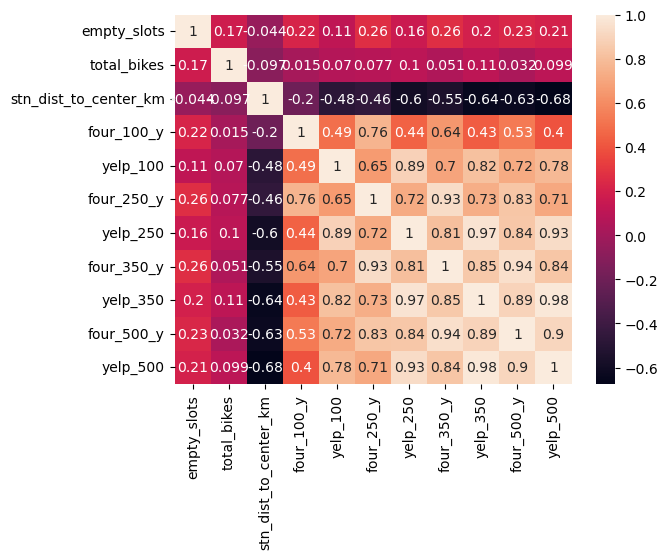

In [27]:
sns.heatmap(Helsinki_numeric.corr(), annot = True)
plt.show()

There are a few things that stand out. It appears that yelp and foursquare perform more similarly as the distance to the bike station increases. As well, there is no correlation between total bikes at bike stations and distance to downtown. There is a correlation between the number of restuarants and the distance to downtown, though, which also makes sense.

In [28]:
Helsinki_yelpfour_bydist = Helsinki_bikestation[['stn_dist_to_center_km','four_100_y','yelp_100','four_250_y','yelp_250',
                                       'four_350_y','yelp_350','four_500_y','yelp_500']]
# could have used Helsinki_bikestation.select_dtypes(include = 'number') if I wanted all number columns.

In [29]:
exp_plot = Helsinki_yelpfour_bydist.sort_values(by="stn_dist_to_center_km")
exp_plot

,stn_dist_to_center_km,four_100_y,yelp_100,four_250_y,yelp_250,four_350_y,yelp_350,four_500_y,yelp_500
26,0.048506,53,4,180,20,364,70,560,140
22,0.162194,66,13,232,77,395,131,661,228
20,0.250876,57,2,193,46,356,108,670,208
64,0.278321,52,14,179,61,320,104,561,182
28,0.319828,30,7,96,12,226,21,418,53
...,...,...,...,...,...,...,...,...,...
109,3.347373,13,0,56,3,77,5,146,18
88,3.380350,3,0,32,5,131,7,249,9
110,3.398088,6,0,24,0,57,1,127,7
121,3.473536,1,1,22,2,28,2,103,3


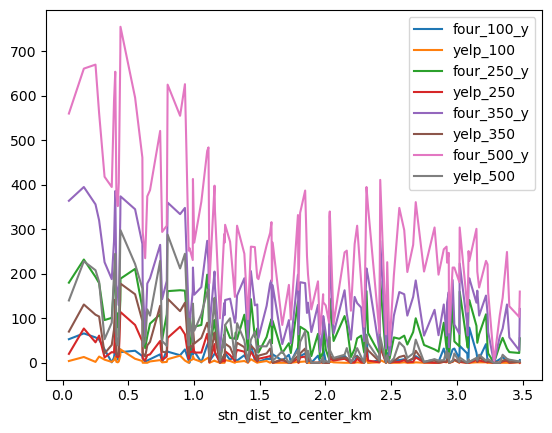

In [30]:
exp_plot.plot("stn_dist_to_center_km")
plt.savefig('eda_countbydistancetodowntown.png')

In [31]:
exp2 = exp_plot.transpose()
exp2

,26,22,20,64,28,114,18,19,29,112,...,118,80,108,122,42,109,88,110,121,120
stn_dist_to_center_km,0.048506,0.162194,0.250876,0.278321,0.319828,0.37446,0.391688,0.401263,0.409807,0.420348,...,3.220742,3.232741,3.237331,3.281873,3.325779,3.347373,3.38035,3.398088,3.473536,3.477867
four_100_y,53.000000,66.000000,57.000000,52.000000,30.000000,1.00000,12.000000,35.000000,20.000000,7.000000,...,42.000000,3.000000,6.000000,0.000000,8.000000,13.000000,3.00000,6.000000,1.000000,6.000000
yelp_100,4.000000,13.000000,2.000000,14.000000,7.000000,2.00000,6.000000,13.000000,2.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
four_250_y,180.000000,232.000000,193.000000,179.000000,96.000000,101.00000,175.000000,210.000000,80.000000,111.000000,...,109.000000,35.000000,21.000000,0.000000,40.000000,56.000000,32.00000,24.000000,22.000000,55.000000
yelp_250,20.000000,77.000000,46.000000,61.000000,12.000000,24.00000,23.000000,81.000000,14.000000,13.000000,...,2.000000,1.000000,2.000000,0.000000,0.000000,3.000000,5.00000,0.000000,2.000000,0.000000
four_350_y,364.000000,395.000000,356.000000,320.000000,226.000000,188.00000,273.000000,386.000000,175.000000,159.000000,...,151.000000,110.000000,69.000000,0.000000,59.000000,77.000000,131.00000,57.000000,28.000000,121.000000
yelp_350,70.000000,131.000000,108.000000,104.000000,21.000000,40.00000,75.000000,142.000000,23.000000,17.000000,...,3.000000,7.000000,3.000000,0.000000,0.000000,5.000000,7.00000,1.000000,2.000000,2.000000
four_500_y,560.000000,661.000000,670.000000,561.000000,418.000000,395.00000,588.000000,654.000000,378.000000,352.000000,...,229.000000,221.000000,158.000000,3.000000,107.000000,146.000000,249.00000,127.000000,103.000000,160.000000
yelp_500,140.000000,228.000000,208.000000,182.000000,53.000000,90.00000,200.000000,245.000000,47.000000,39.000000,...,5.000000,7.000000,8.000000,0.000000,0.000000,18.000000,9.00000,7.000000,3.000000,3.000000


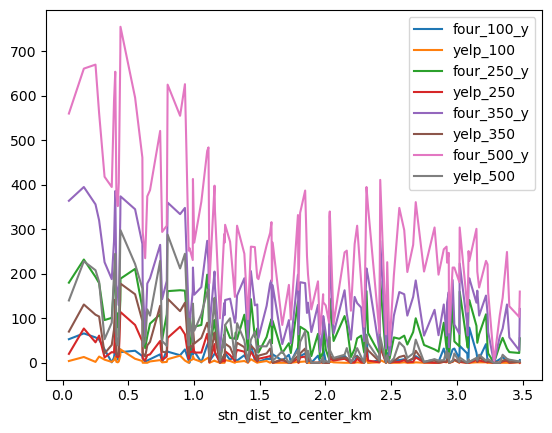

In [32]:
fig1 = exp_plot.plot("stn_dist_to_center_km").get_figure()
fig1.savefig('eda_countbydistancetodowntown.pdf')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 [Text(-1.0, 0, 'yelp_500'),
  Text(0.0, 0, 'stn_dist_to_center_km'),
  Text(1.0, 0, 'four_100_y'),
  Text(2.0, 0, 'yelp_100'),
  Text(3.0, 0, 'four_250_y'),
  Text(4.0, 0, 'yelp_250'),
  Text(5.0, 0, 'four_350_y'),
  Text(6.0, 0, 'yelp_350'),
  Text(7.0, 0, 'four_500_y'),
  Text(8.0, 0, 'yelp_500'),
  Text(9.0, 0, '')])

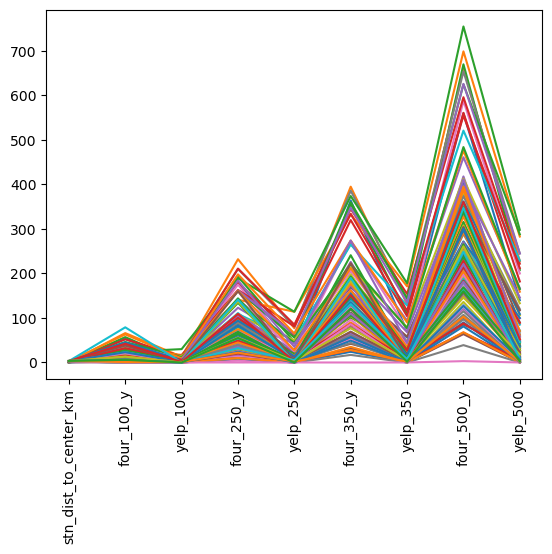

In [36]:
fig2 = exp2.plot(legend=False).get_figure()
plt.xticks(rotation=90)
fig2.savefig('eda_countbyradiuscomparison.pdf')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 [Text(-1.0, 0, 'yelp_500'),
  Text(0.0, 0, 'stn_dist_to_center_km'),
  Text(1.0, 0, 'four_100_y'),
  Text(2.0, 0, 'yelp_100'),
  Text(3.0, 0, 'four_250_y'),
  Text(4.0, 0, 'yelp_250'),
  Text(5.0, 0, 'four_350_y'),
  Text(6.0, 0, 'yelp_350'),
  Text(7.0, 0, 'four_500_y'),
  Text(8.0, 0, 'yelp_500'),
  Text(9.0, 0, '')])

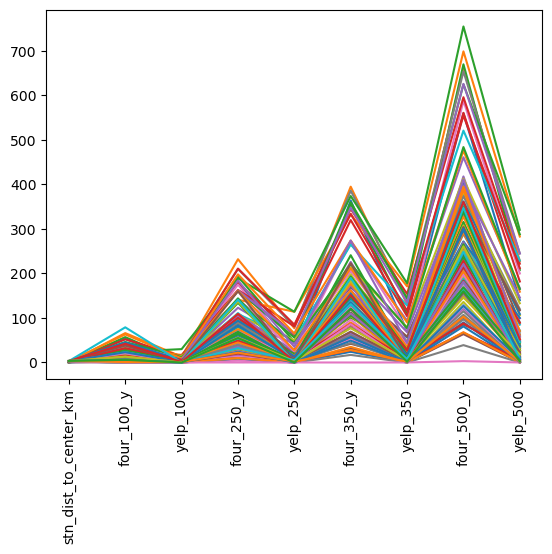

In [37]:
exp2.plot(legend=False)
plt.xticks(rotation=90)
plt.savefig('eda_countbyradiuscomparison.png')

In [38]:
exp3 = exp_plot[['four_100_y','yelp_100','four_250_y','yelp_250',
                                       'four_350_y','yelp_350','four_500_y','yelp_500']]

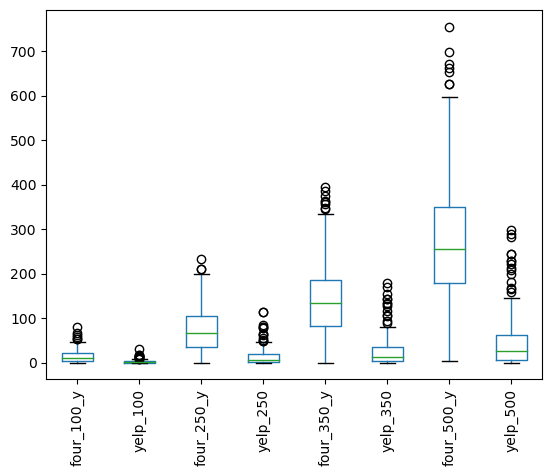

In [39]:
exp3.boxplot(grid=False)
plt.xticks(rotation=90)
plt.savefig('eda_boxplot.png')

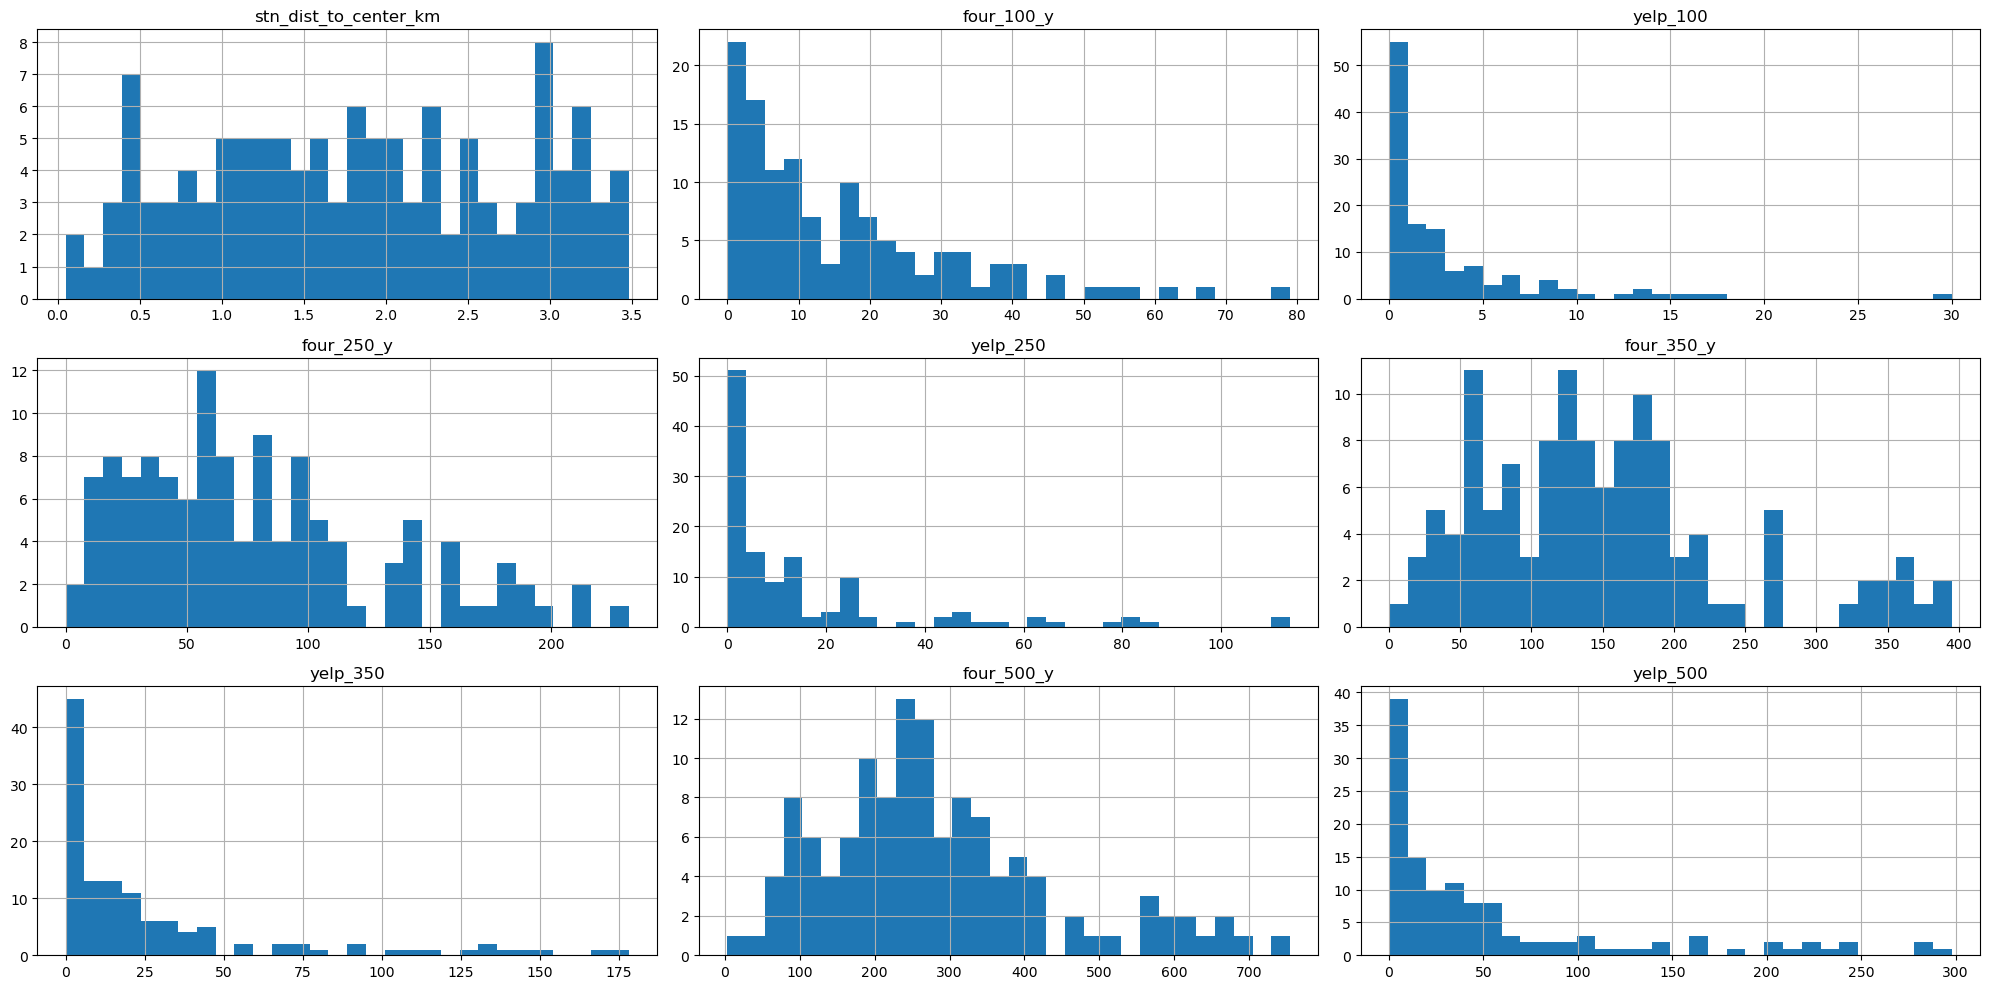

<Figure size 640x480 with 0 Axes>

In [40]:
exp_plot.hist(bins=30,figsize=(20, 10))
plt.tight_layout()
plt.show()
plt.savefig('eda_histograms.png')

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Look at the data before and after the join to validate your data.